General optimizations:
- Diro2C generation algorithm could take into account possible values for categorical features or integer features
- scikit-learn Decision tree implementation does not support categorical values, they are currently only approximated by converting them to numbers. Look into alternative implementations or encode values
- it would be better for the understanding, to see how rules evolve with increasing max depth. I used unix diff for that
- general rule for determining, how far to increase max depth parameter

In [1]:
import matplotlib.pyplot as plt
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.ticker import MaxNLocator
from comparers import ModelComparer, plot_decision_boundary
from diro2c_wrapper import WrappedDiro2C, plot_diro2c_2d, get_pruned_trees, eval_diro2c
from surrogate_tree import get_feature_importances, plot_feature_importances, plot_surrogate_tree,\
                           extract_rules, print_rules, plot_tree_leafs_for_class
from util import RuleClassifier, evaluate_counterfactual_fidelity, get_complexity, group_metrics

In [2]:
with open('task.pickle', 'rb') as f:
    clf_a, clf_b, X, X_display, y, feature_names, categorical_features, feature_precisions = pickle.load(f)

In [3]:
comparer = ModelComparer(clf_a, clf_b, feature_names)

In [4]:
mclass_diff = comparer.predict_mclass_diff(X)

# Explanations

In [ ]:
%%time
for class_name in comparer.class_names:
    print(class_name)
    explainer = WrappedDiro2C(X, comparer, class_name)
    explanation = explainer.generate_global_explanation()
    with open(f'diro2c-data/diro2c.{class_name}.pickle', 'wb') as f:
        pickle.dump(explanation, f, pickle.HIGHEST_PROTOCOL)

This was run on a different machine (Intel(R) Xeon(R) CPU E5-2676 v3 @ 2.40GHz):
- (False, False)... 0:23:27.003971
- (False, True)... 0:46:55.708892
- (True, False)... 1:10:22.483679
- (True, True)... 1:33:50.727428

## $(0,1)$

In [102]:
focus_class = '(False, True)'
y_true = comparer.class_names[mclass_diff] == focus_class
class_names = ['other', focus_class]

In [103]:
with open(f'diro2c-data/diro2c.{focus_class}.pickle', 'rb') as f:
    explanation = pickle.load(f)

In [104]:
%%time
trees = get_pruned_trees(explanation)
tree_it = iter(trees)
len(trees)

CPU times: user 84.1 ms, sys: 3.4 ms, total: 87.5 ms
Wall time: 107 ms


2

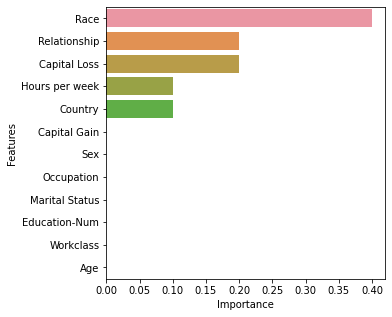

In [105]:
feature_importances, feature_order = get_feature_importances(trees[-1])
plot_feature_importances(feature_names, feature_importances, feature_order, figsize=(5, 5))

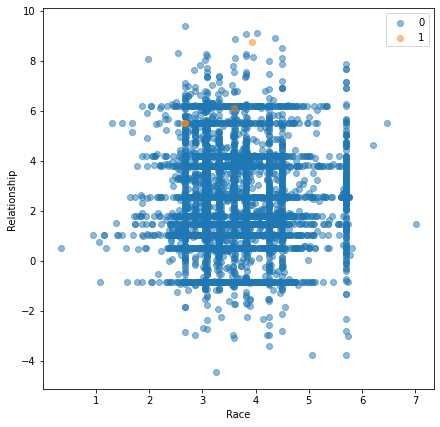

In [106]:
plot_diro2c_2d(explanation, 'Race', 'Relationship')

### 3 Leafs

In [37]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(7.148984039589265e-05, 2, 3)

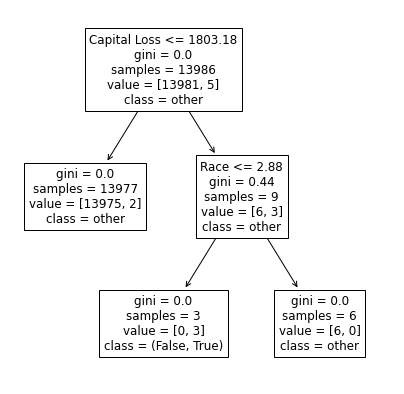

In [38]:
plot_surrogate_tree(tree, feature_names, class_names, precision=2, figsize=(7, 7))

In [39]:
constraints, rules, class_occurences, labels = extract_rules(tree, feature_names, comparer.difference_classes)
print_rules(rules, class_occurences, class_names, labels)

1. Race <= 2.8822784423828125 and `Capital Loss` > 1803.1835327148438 => (False, True) [0, 3]


### 7 Leafs

In [40]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.0, 4, 7)

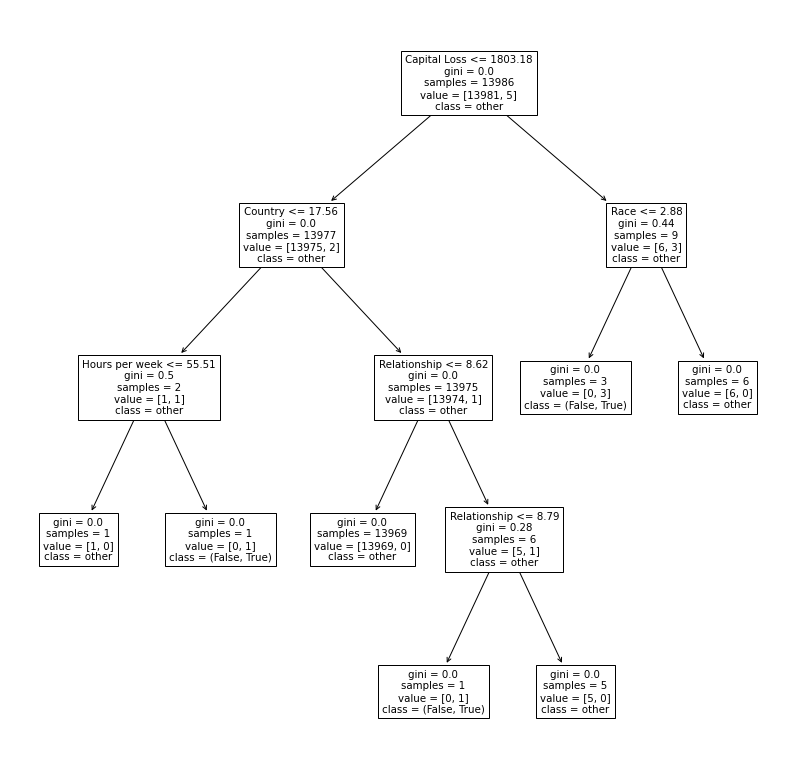

In [41]:
plot_surrogate_tree(tree, feature_names, class_names, precision=2, figsize=(14, 14))

In [42]:
constraints, rules, class_occurences, labels = extract_rules(tree, feature_names, comparer.difference_classes)
print_rules(rules, class_occurences, class_names, labels)

1. Race <= 2.8822784423828125 and `Capital Loss` > 1803.1835327148438 => (False, True) [0, 3]
2. 8.619791030883789 < Relationship <= 8.792388439178467 and `Capital Loss` <= 1803.1835327148438 and Country > 17.559858322143555 => (False, True) [0, 1]
3. `Capital Loss` <= 1803.1835327148438 and `Hours per week` > 55.51257133483887 and Country <= 17.559858322143555 => (False, True) [0, 1]


## $(1,0)$

In [97]:
focus_class = '(True, False)'
y_true = comparer.class_names[mclass_diff] == focus_class
class_names = ['other', focus_class]

In [98]:
with open(f'diro2c-data/diro2c.{focus_class}.pickle', 'rb') as f:
    explanation = pickle.load(f)

In [99]:
%%time
trees = get_pruned_trees(explanation)
tree_it = iter(trees)
len(trees)

CPU times: user 4.05 s, sys: 53.1 ms, total: 4.11 s
Wall time: 5.12 s


93

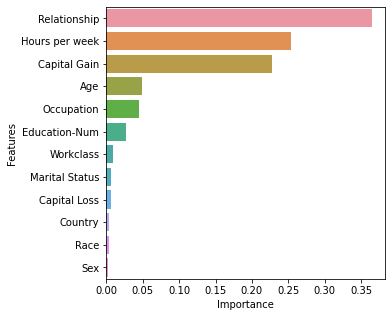

In [100]:
feature_importances, feature_order = get_feature_importances(trees[-1])
plot_feature_importances(feature_names, feature_importances, feature_order, figsize=(5, 5))

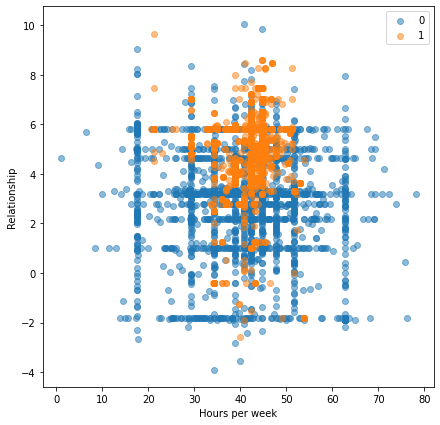

In [101]:
plot_diro2c_2d(explanation, 'Hours per week', 'Relationship')

### 2 Leafs

In [46]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.07222009608355562, 1, 2)

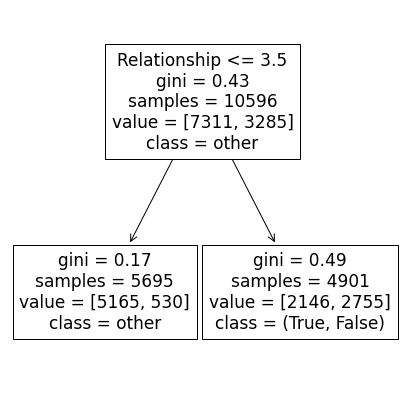

In [48]:
plot_surrogate_tree(tree, feature_names, class_names, precision=2, figsize=(7, 7))

In [49]:
constraints, rules, class_occurences, labels = extract_rules(tree, feature_names, comparer.difference_classes)
print_rules(rules, class_occurences, class_names, labels)

1. Relationship > 3.497862458229065 => (True, False) [2146, 2755]


### 3 Leafs

In [50]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.0717934304293954, 2, 3)

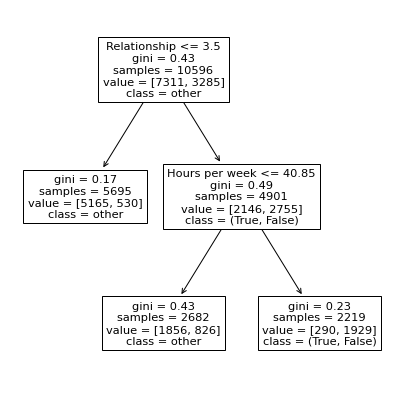

In [52]:
plot_surrogate_tree(tree, feature_names, class_names, precision=2, figsize=(7, 7))

In [53]:
constraints, rules, class_occurences, labels = extract_rules(tree, feature_names, comparer.difference_classes)
print_rules(rules, class_occurences, class_names, labels)

1. Relationship > 3.497862458229065 and `Hours per week` > 40.84784698486328 => (True, False) [290, 1929]


### 4 Leafs

In [54]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.04208836461761459, 2, 4)

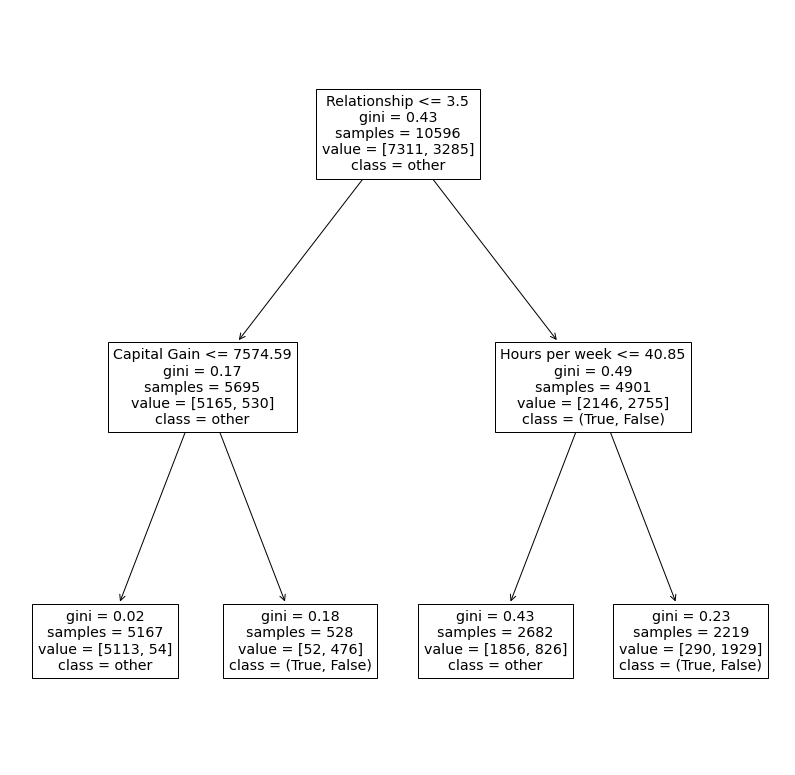

In [58]:
plot_surrogate_tree(tree, feature_names, class_names, precision=2, figsize=(14, 14))

In [57]:
constraints, rules, class_occurences, labels = extract_rules(tree, feature_names, comparer.difference_classes)
print_rules(rules, class_occurences, class_names, labels)

1. Relationship > 3.497862458229065 and `Hours per week` > 40.84784698486328 => (True, False) [290, 1929]
2. Relationship <= 3.497862458229065 and `Capital Gain` > 7574.592041015625 => (True, False) [52, 476]


### 5 Leafs

In [59]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.014232473177722943, 3, 5)

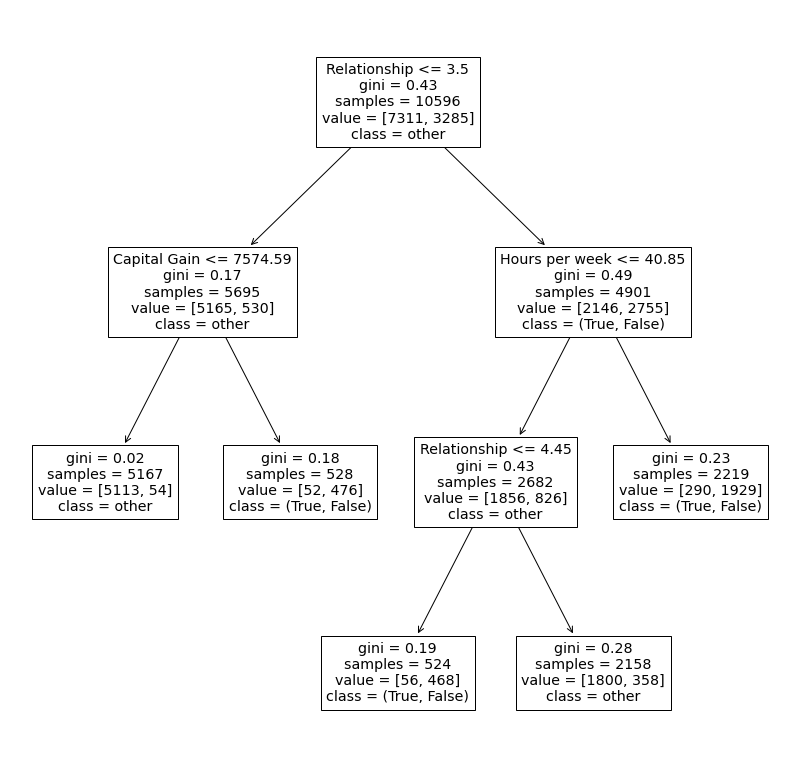

In [61]:
plot_surrogate_tree(tree, feature_names, class_names, precision=2, figsize=(14, 14))

In [62]:
constraints, rules, class_occurences, labels = extract_rules(tree, feature_names, comparer.difference_classes)
print_rules(rules, class_occurences, class_names, labels)

1. Relationship > 3.497862458229065 and `Hours per week` > 40.84784698486328 => (True, False) [290, 1929]
2. Relationship <= 3.497862458229065 and `Capital Gain` > 7574.592041015625 => (True, False) [52, 476]
3. 3.497862458229065 < Relationship <= 4.445602893829346 and `Hours per week` <= 40.84784698486328 => (True, False) [56, 468]


### 6 Leafs

In [63]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.013237804941543016, 4, 6)

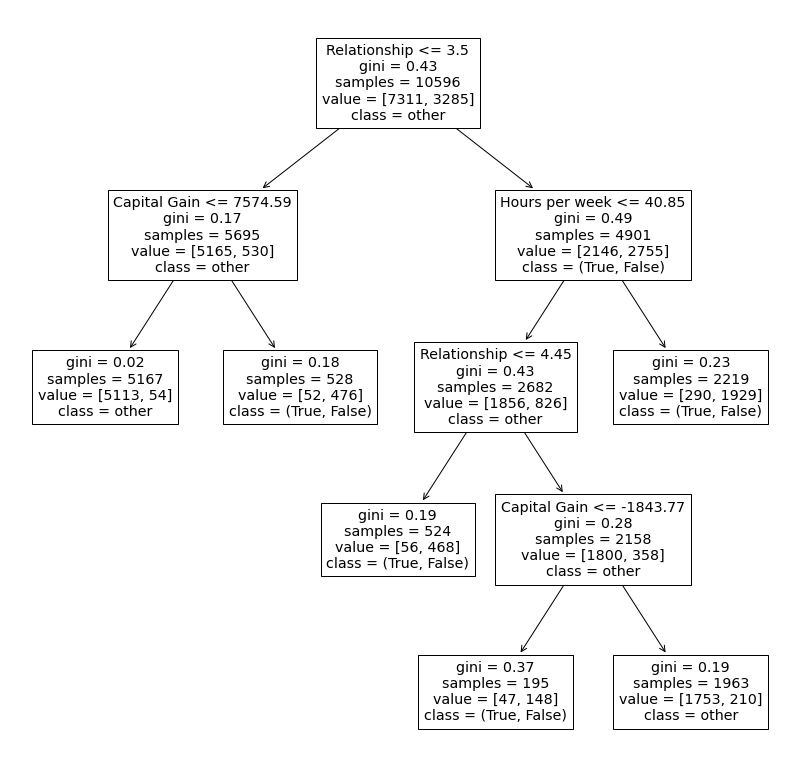

In [65]:
plot_surrogate_tree(tree, feature_names, class_names, precision=2, figsize=(14, 14))

In [66]:
constraints, rules, class_occurences, labels = extract_rules(tree, feature_names, comparer.difference_classes)
print_rules(rules, class_occurences, class_names, labels)

1. Relationship > 3.497862458229065 and `Hours per week` > 40.84784698486328 => (True, False) [290, 1929]
2. Relationship <= 3.497862458229065 and `Capital Gain` > 7574.592041015625 => (True, False) [52, 476]
3. 3.497862458229065 < Relationship <= 4.445602893829346 and `Hours per week` <= 40.84784698486328 => (True, False) [56, 468]
4. Relationship > 4.445602893829346 and `Capital Gain` <= -1843.772216796875 and `Hours per week` <= 40.84784698486328 => (True, False) [47, 148]


### 7 Leafs

In [67]:
tree = next(tree_it)
tree.ccp_alpha, tree.get_depth(), tree.get_n_leaves()

(0.007023069306093532, 4, 7)

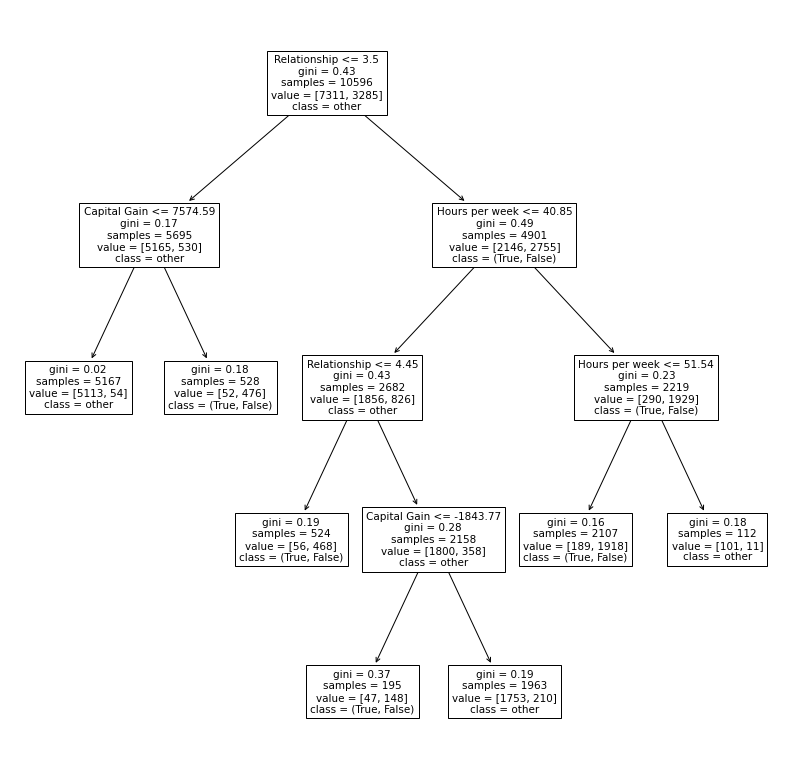

In [69]:
plot_surrogate_tree(tree, feature_names, class_names, precision=2, figsize=(14, 14))

In [70]:
constraints, rules, class_occurences, labels = extract_rules(tree, feature_names, comparer.difference_classes)
print_rules(rules, class_occurences, class_names, labels)

1. Relationship > 3.497862458229065 and 40.84784698486328 < `Hours per week` <= 51.54051208496094 => (True, False) [189, 1918]
2. Relationship <= 3.497862458229065 and `Capital Gain` > 7574.592041015625 => (True, False) [52, 476]
3. 3.497862458229065 < Relationship <= 4.445602893829346 and `Hours per week` <= 40.84784698486328 => (True, False) [56, 468]
4. Relationship > 4.445602893829346 and `Capital Gain` <= -1843.772216796875 and `Hours per week` <= 40.84784698486328 => (True, False) [47, 148]


# Evaluation

In [71]:
with open('test.pickle', 'rb') as f:
    X_test, X_display_test, y_test = pickle.load(f)

In [73]:
explanations_per_class = {}
for class_name in comparer.class_names:
    with open(f'diro2c-data/diro2c.{class_name}.pickle', 'rb') as f:
        explanations_per_class[class_name] = pickle.load(f)

In [76]:
len(X_test)

4785

In [77]:
len(y_test)

4785

In [82]:
y_test

array([False,  True, False, ..., False,  True,  True])

In [83]:
from importlib import reload
import diro2c_wrapper
reload(diro2c_wrapper)
from diro2c_wrapper import *

In [84]:
metrics = eval_diro2c(explanations_per_class, X_test, y_test, comparer.class_names)
metrics

Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this be

,Precision,Recall,F1 Score,Support,Label,Leafs,Alpha,Rules,Constraints
1,0.935385,0.669419,0.780363,3633.0,"(False, False)",2.0,0.045746,1.0,1.0
1,0.877522,0.861822,0.869601,3633.0,"(False, False)",3.0,0.044047,2.0,3.0
1,0.890380,0.858519,0.874159,3633.0,"(False, False)",6.0,0.024094,3.0,8.0
1,0.890380,0.858519,0.874159,3633.0,"(False, False)",6.0,0.012628,3.0,8.0
1,0.890634,0.858519,0.874282,3633.0,"(False, False)",8.0,0.007216,4.0,12.0
...,...,...,...,...,...,...,...,...,...
1,0.000000,0.000000,0.000000,0.0,"(True, True)",255.0,0.000057,126.0,1110.0
1,0.000000,0.000000,0.000000,0.0,"(True, True)",257.0,0.000050,127.0,1121.0
1,0.000000,0.000000,0.000000,0.0,"(True, True)",262.0,0.000041,129.0,1136.0
1,0.000000,0.000000,0.000000,0.0,"(True, True)",265.0,0.000041,130.0,1145.0


In [85]:
grouped_metrics, constraints = group_metrics(metrics, by='Alpha')

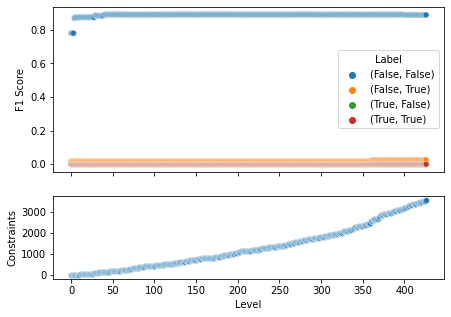

In [86]:
fig, axs = plt.subplots(nrows=2, figsize=(7, 5), sharex='all', gridspec_kw={'height_ratios': [2,1]})
sns.scatterplot(data=grouped_metrics, x='Level', y='F1 Score', hue='Label', alpha=0.8, ax=axs[0])
sns.scatterplot(data=constraints, ax=axs[1])
axs[1].xaxis.set_major_locator(MaxNLocator(integer=True))
plt.savefig('gaussian-diro2c-fidelity.pdf')

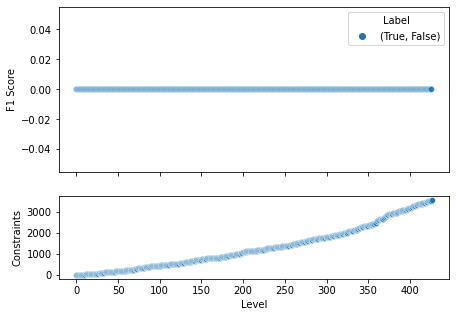

In [87]:
fig, axs = plt.subplots(nrows=2, figsize=(7, 5), sharex='all', gridspec_kw={'height_ratios': [2,1]})
sns.scatterplot(data=grouped_metrics[grouped_metrics['Label'] == '(True, False)'], x='Level', y='F1 Score', hue='Label', alpha=0.8, ax=axs[0])
sns.scatterplot(data=constraints, ax=axs[1])
axs[1].xaxis.set_major_locator(MaxNLocator(integer=True))
plt.savefig('gaussian-diro2c-fidelity.pdf')

In [91]:
grouped_metrics[grouped_metrics['Label'] == '(True, False)'].describe()

,Precision,Recall,F1 Score,Support,Leafs,Alpha,Rules,Constraints
count,427.0,427.0,427.0,427.0,427.000000,427.000000,427.000000,427.000000
mean,0.0,0.0,0.0,0.0,85.021077,0.001352,41.461358,282.826698
std,0.0,0.0,0.0,0.0,44.460427,0.006479,22.304030,171.237331
min,0.0,0.0,0.0,0.0,2.000000,0.000000,1.000000,1.000000
25%,0.0,0.0,0.0,0.0,48.000000,0.000095,24.000000,146.000000
50%,0.0,0.0,0.0,0.0,84.000000,0.000186,39.000000,267.000000
75%,0.0,0.0,0.0,0.0,110.000000,0.000499,54.000000,368.000000
max,0.0,0.0,0.0,0.0,150.000000,0.072220,74.000000,544.000000


In [92]:
grouped_metrics[grouped_metrics['Label'] == '(False, True)'].describe()

,Precision,Recall,F1 Score,Support,Leafs,Alpha,Rules,Constraints
count,427.000000,427.000000,427.000000,427.0,427.000000,427.000000,427.000000,427.000000
mean,0.790398,0.009351,0.018459,1152.0,3.618267,0.000060,1.309133,3.081967
std,0.100532,0.001571,0.002991,0.0,1.447661,0.000026,0.723830,2.533406
min,0.555556,0.008681,0.017182,1152.0,3.000000,0.000000,1.000000,2.000000
25%,0.833333,0.008681,0.017182,1152.0,3.000000,0.000071,1.000000,2.000000
50%,0.833333,0.008681,0.017182,1152.0,3.000000,0.000071,1.000000,2.000000
75%,0.833333,0.008681,0.017182,1152.0,3.000000,0.000071,1.000000,2.000000
max,0.833333,0.013021,0.025445,1152.0,7.000000,0.000071,3.000000,9.000000


In [88]:
grouped_metrics

Label  Precision    Recall  F1 Score  Support  Leafs  \
Level                                                                    
0     0  (False, False)   0.935385  0.669419  0.780363   3633.0    2.0   
      1   (False, True)   0.833333  0.008681  0.017182   1152.0    3.0   
      2   (True, False)   0.000000  0.000000  0.000000      0.0    2.0   
      3    (True, True)   0.000000  0.000000  0.000000      0.0    3.0   
1     0  (False, False)   0.935385  0.669419  0.780363   3633.0    2.0   
...                 ...        ...       ...       ...      ...    ...   
425   3    (True, True)   0.000000  0.000000  0.000000      0.0  268.0   
426   0  (False, False)   0.870908  0.908065  0.889099   3633.0  423.0   
      1   (False, True)   0.555556  0.013021  0.025445   1152.0    7.0   
      2   (True, False)   0.000000  0.000000  0.000000      0.0  150.0   
      3    (True, True)   0.000000  0.000000  0.000000      0.0  268.0   

            Alpha  Rules  Constraints  
Level                                  
0     0  0.045746    1.0          1.0  
      1  0.000071    1.0          2.0  
      2  0.072220    1.0          1.0  
      3  0.053435    2.0          3.0  
1     0  0.045746    1.0          1.0  
...           ...    ...          ...  
425   3  0.000000  132.0       1172.0  
426   0  0.000000  209.0       1830.0  
      1  0.000000    3.0          9.0  
      2  0.000000   74.0        544.0  
      3  0.000000  132.0       1172.0  

[1708 rows x 9 columns]

In [89]:
constraints

Level
0         7.0
1         8.0
2        10.0
3        14.0
4        16.0
        ...  
422    3506.0
423    3517.0
424    3525.0
425    3539.0
426    3555.0
Name: Constraints, Length: 427, dtype: float64